# Creating a training database for dolphin clicks by importing Pamguard CSV annotation files
(CLICKLEARN DSTI Project)


The objective of this notebook is to rework and adapt Ketos *Creating Database (Extended)* notebook (
https://docs.meridian.cs.dal.ca/ketos/tutorials/create_database/index.html) for **Pamguard software** users.
Pamguard is an open source software which objective is to provide free and easy to handle tools for cetacean passive acoustic monitoring (PAM): https://www.pamguard.org/.

All the content of this notebook (Chapters 1 to 8) replaces the original one :

* Chapters 1 to 2 complete original chapter 2, by providing methods to load a CSV file exported by **Pamguard software**, and convert it as Ketos annotation table, dealing with datetime and timedelta operations. The original notebook described methods to import CSV files which already match to the Ketos requirements, but not to import and convert other CSV files.
* Chapter 3 provides a method to put every WAV file in a unique folder, as required by Ketos before automatically building a database.
* Chapter 4 to 8 are specific to ClickLearn project. They will process the dataframes built in chapter 1 & 2 to build the HDF5 database that will be used to train the model.


Two types of CSV file exported by Pamguard can be used with these methods. One section of this notebook will be dedicated to each type :

* **Events annotation CSV files**: quoting start and end of time ranges (several seconds long) in which clicks streams have been identified.
* **Clicks annotation CSV files**: quoting start time of identified clicks. Click duration is about few milliseconds and has to be set in parameters (see below).

The converted annotation tables will then be ready to be directly used by Ketos library (see Chapter 4 and followings). **For a first training, only the Events annotation CSV files will be used to train the model.**

Steps 1 to 4 of the prsent notebook, with main Pandas methods used, are illustrated in the following figure:

<br><br>
<img src="img/building_database_notebook_steps.jpg" alt="building database steps" style="width: 70%;"/>



## Contents:

[1. Imports and settings](#section1)  
[2a. Building annotation files from Events Annotations CSV files](#section2a)  
[2b. Building annotation files from Clicks Annotations CSV files](#section2b)  
[3. Grouping all .WAV files in a same folder](#section3)  
[4. Standardize Ketos annotation tables](#section4)  
[5. Creating segments of uniform length and augmenting the data](#section5)  
[6. Including background noise](#section6)  
[7. Choosing the spectrogram settings](#section7)  
[8. Creating the database](#section8)  




<a id="section1"></a>
## 1. Imports and settings

### Importing the packages

We will use several modules within ketos and also the pandas package



In [2]:
import os
import numpy as np
import pandas as pd
from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.audio.spectrogram import MagSpectrogram
from ketos.data_handling.parsing import load_audio_representation

from datetime import datetime
from typing import Union
import math
import random
import librosa
import ffmpeg

# This last package is made by ClickLearn DSTI team to extract informations from a Pamguard CSV export file 
# and buid a Ketos annotation table (Pandas dataframe)
# from ketos_annotation_table import list_pamguard_wav_files, pamguard_events_annotations_csv_to_df, strip_dataframe, check_pamguard_annotation_df, subsample_dataframe

### Import functions



In [19]:
def list_pamguard_wav_files(wav_files_path):
    """Lists every wav files contained in a directory tree. The structuure of file names is specific to pamguard.
        Args:
            filename : str
                PAMGUARD .wav or audio_file name. 
                filename must:
                    * begin with the subsampling frequency (48 or 192 kHz)
                    * contain the datetime with following format: "YYYYmmdd_HHMMSS_f"
                    * end with ".wav"
                example: 048_20180528_003358_587.wav  
        Returns:
            Pandas Dataframe
                DataFrame with 2 columns:
                    filestart: absolute UTC datetime value at which the wav file record starts
                    filename: name of the wav file
    """
    file_list = []
    for root, directory, files in os.walk(wav_files_path):
        for file in files:
            if file.endswith('wav'):
                # for some reason, some file names always appear starting with "._". They are renamed:
                if file.startswith('._'):
                    print(f'Name of file {file} renamed into {file[2:]}')
                    file = file[2:]
                duration = librosa.get_duration(filename=os.path.join(root,file))
                
                file_list.append([datetime.strptime(file[-23:-4], '%Y%m%d_%H%M%S_%f'), duration, file])
    file_list.sort()
    return pd.DataFrame(file_list, columns = ['filestart', 'duration', 'filename'])

In [16]:
def pamguard_events_annotations_csv_to_df(annotation_csv_path:str, wav_files_dataframe, events_subsampling_option:int = 2):
    """Converts a Pamguard CSV annotation file into a non standardized Ketos annotation table. 
        Args:
            annotation_csv_path: str
                complete path of the annotation CSV file. CSV separator must be ','
                CSV file must have following columns:
                    'comment': comment associated 
            wav_files_dataframe: Pandas DataFrame
                DataFrame listing all WAV files that annotation CSV file refer to. 
                This DataFrame has 3 columns: 
                    filename:str
                        name of the wav file
                    filestart: datetime
                        absolute UTC time at which the wav file starts
                    filesend: datetime
                        absolute UTC time at which the wav file ends                        
            events_subsampling_option: int
                Subsampling is optional but highly recommended to avoid unsure detections. 
                From the less to the most selective option:
                - 0: no subsampling. All detections (sure, unsure...) are kept
                - 1: subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
                - 2 (default value): subsample excluding all commented detections in 'comment' column 
                    (comments always refer to unsure detections), 
                    then including only 'definite' dolphin click detections ('DLD')
               
        Returns:
            annotations_df: pd.DataFrame
                Ketos annotation table (non standardized)
    """

    # import CSV in a dataframe
    annotations_df = pd.read_csv(annotation_csv_path, sep=",")

    # Remove all whitespaces from string typed series of the dataframe 
    annotations_df = strip_dataframe(annotations_df)

    # SUBSAMPLING (SPECIFIC TO EVENT ANNOTATION DF, with option 2 > 1 > 0, check docstring):
    if events_subsampling_option == 2:
        annotations_df = annotations_df.loc[((annotations_df.comment.isna()) 
                                             & (annotations_df.eventType == 'DLD') | (annotations_df.eventType == 'other')),]
    if events_subsampling_option == 1:
        annotations_df = annotations_df.loc[(annotations_df.comment.isna()),]    

    # updating pd.Series type from string to datetime
    annotations_df = annotations_df.rename(columns = {'UTC':'start', 'EventEnd':'end', 'eventType':'label'})
    annotations_df.start = pd.to_datetime(annotations_df.start, format = '%Y-%m-%d %H:%M:%S.%f')
    annotations_df.end = pd.to_datetime(annotations_df.end, format = '%Y-%m-%d %H:%M:%S.%f')


    # computing start and end time from beginning of the file
    # + creating a new column to add .wav filenames
    annotations_df['filename']=""
    annotations_df = annotations_df.reset_index()
    for index, row in annotations_df.iterrows():
        try:
            # select all the wav files that starts before or at the same time than "start" value,
            # then pick the closest one to this "start" value among the selection (the last index):
            matching_loc = wav_files_dataframe.loc[(wav_files_dataframe.filestart <= row.start)].iloc[-1]
            annotations_df.filename[index] = matching_loc['filename']
            annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
            annotations_df.end[index] = (annotations_df.end[index] - matching_loc['filestart'])
        except:
            pass


    #convert 'start' in seconds
    annotations_df['start'] = annotations_df.start.apply(pd.Timedelta.total_seconds)
    annotations_df['end'] = annotations_df.end.apply(pd.Timedelta.total_seconds)
    
    # select only columns required in Ketos annotation table
    annotations_df = annotations_df.loc[:,('start', 'end', 'label', 'filename')]

    # Check start and end values of events annotation df
    annotations_df = check_pamguard_annotation_df(annotations_df, wav_files_dataframe)[0]
    
    return annotations_df

In [17]:
def strip_dataframe(df):
    """Removes any white space before and after value of every cells of a dataframe.
        Args:
            df: pd.DataFrame
        Returns:
            df: pd.DataFrame
    """
    for column in df:
        if isinstance(df[column][0], str):
            df[column] = df[column].str.strip()
    return df

In [20]:
def check_pamguard_annotation_df(df, wav_files_dataframe):
    """Check Check time validity on annotations from a CSV file extracted from Pamguard software. 
        Uses check_annotation in a loop.
    
        Args:
            df: Pandas DataFrame
                Pamguard annotation DataFrame converted by the pamguard_annotations_csv_to_df() method.
            wav_files_dataframe: Pandas DataFrame
                DataFrame listing all WAV files that annotation CSV file refer to. 
                This DataFrame has 3 columns: 
                    filename:str
                        name of the wav file
                    filestart: datetime
                        absolute UTC time at which the wav file starts
                    filesend: datetime
                        absolute UTC time at which the wav file ends  
        Returns: 
            df: Pandas DataFrame
                Pamguard annotation DataFrame.
            errors: list
                List of errors containing each incorrect annotation
    """
    errors = []

    for index, row in df.iterrows():
        # row.start : start time of the annotation, in seconds from the beginning of the file
        # row.end : end time of the annotation, in seconds from the beginning of the file
        if row.start > row.end: 
            errors.append(f'Id {index}: end value ({row.end}) is prior to start value ({row.start})')
        # ASI campaign wav files max duration = 3600 (all subsamplings considered)
        # if row.start is above this duration, it means that no avaible file contains 
        # the present annotated sound and should be deleted  
        if row.start > 3600:
            df = df.drop(index = index)
            errors.append(f'Id {index}: start value ({row.start}) is above 3600, row has been deleted')
        # set maximum end time at 3600 seconds
        else:            
            if row.end > 3600:
                # next_annot_end = row.end - 3600
                df.end[index] = 3600
            # locate annotations which duration ends outside a wav file,
            # shorten annotation duration to be completely included in the file
            matching_index = wav_files_dataframe.index[wav_files_dataframe.filename == row.filename][0]
            file_end  = wav_files_dataframe.iloc[matching_index]['duration']
            if row.end > file_end:
                df.end[index] = file_end
                errors.append(f'Id {index}: annotation end value ({row.end}) crosses .WAV file end value ({file_end}), annotation has been shortened')

    # reseting indexes is safer for further use of the DataFrame 
    df = df.reset_index()
    print('Dataframe check sucessful. All indexes are reseted')
    if errors:
        print('Following errors occured:')
        for error in errors:
            print(error)
    return df, errors

In [6]:
def subsample_dataframe(df_to_subsample, train_proportion:float):
    """Randomly subsamples a Pandas DataFrame into a Train and a Test subsamples, based on row index.
        Args:
            df_to_subsample: pd.DataFrame
                DataFrame to subsample
            train_proportion: float
                proportion (]0;1[) of DataFrame rows to subsample, in order to build the Train dataset
    
        Returns: tuple with 2 dataframes:
            [0] train subsample 
            [1] test subsamples
    """
    length = len(df_to_subsample)
    nb_train_rows = math.ceil(train_proportion*length)
    #create a sequence corresponding to df indexes to subsample 
    sequence = set(range(length))
    train_indexes = random.sample(sequence, nb_train_rows)
    test_indexes = list(sequence - set(train_indexes))
    return df_to_subsample.iloc[train_indexes], df_to_subsample.iloc[test_indexes]

### Path settings


This part contains all required settings to build annotation dataframes:
* Audio files path (where all audio files are stored)
* File path, where: 
    + CSV fils are stored and Annotation tables **will be** stored
    + Sound files are stored
* Click duration in milliseconds (for Click annotation CSV files)
* Set of valid labels to be used (all labels from CSV file that are not matching this set will be stored in an error log file)

In [21]:
# PATH SETTINGS
# Annotation CSV file folder path (MAC)
annotations_folder_path ='/Users/benoitmialet/Ketos/ClickLearn/'
# Annotation CSV file folder path (W10)
# annotations_folder_path = (r'D:\SYSTEL\Ketos\clicklearn')
# Annotation CSV file name
positive_csv_events_name = 'UBISEA_acoustic_detections_samples_events_positive.csv' 
negative_csv_events_name = 'UBISEA_acoustic_detections_samples_events_negative.csv' 
# csv_clicks_name = 'UBISEA_acoustic_detections_samples_clicks.csv'

# Sound file path (MAC)
# sound_files_path = '/Volumes/BENITO/Pelagis - Données acoustiques ASI/Recordings 048 kHz'
sound_files_path = '/Volumes/T7/Recordings 192kHz'
# Sound file path (W10)
# sound_files_path = r'F:\Pelagis - Données acoustiques ASI\Recordings 048 kHz'
# sound_files_path = 'E:\Recordings 192kHz'

# PATH BUILDING
csv_folder_path = annotations_folder_path
positive_csv_events_path = os.path.join(csv_folder_path,positive_csv_events_name)
negative_csv_events_path = os.path.join(csv_folder_path,negative_csv_events_name)
# csv_clicks_path = os.path.join(csv_folder_path,csv_clicks_name)

# # CLICK ANNOTATION SETTINGS 
# # set click duration (milliseconds) for the dataframe
# clickDuration = pd.Timedelta(2.5, unit = 'milliseconds')
# # set label corresponding to a click detection
# label = 'DLD'

<a id="section2a"></a>
## 2a. Building annotation files from **Events Annotations CSV files** 


This section describes methods to create a Ketos annotation table from Pamguard CSV files.

### steps overview:
* Building a wav_df DataFrame with name and start time of every .wav file in sound files folder and sub folders
* Importing a Pamguard CSV file into a Pandas DataFrame:
    + import the CSV file into a dataframe
    + strip blank spaces (strings) in all the dataframe
    + subsample the dataframe regarding the labels (see function details)
    + convert 'start' and 'end' value from string to datetime format
    + add and complete 'filename' column, update 'start' column: for each 'start' value:
        + select rows in wav_df where 'filestart' value <= 'start' value
        + take last index [-1] of this selection 
        + at this index (wav_df), take 'filename' and 'filestart' values
        + copy this 'filename' value in the dataframe, at the right index
        + update 'start' column by computing the time delta in seconds between the dataframe 'start' value and wav_df 'filestart' value
    + convert 'start' and 'end' columns in seconds.


### Building a wav_df dataframe with name and start time of every .wav file in sound files folder and sub folders

For this we use our custom function ```list_wav_files``` that returns a dataframe. This dataframe will be used to find on which .wav file each annotation should be attributed

In [22]:
wav_df = list_pamguard_wav_files(sound_files_path)
wav_df

Name of file ._192_20180701_000000_000.wav renamed into 192_20180701_000000_000.wav
Name of file ._192_20180601_000000_000.wav renamed into 192_20180601_000000_000.wav
Name of file ._192_20180601_080000_000.wav renamed into 192_20180601_080000_000.wav
Name of file ._192_20180601_081528_427.wav renamed into 192_20180601_081528_427.wav
Name of file ._192_20180601_091528_426.wav renamed into 192_20180601_091528_426.wav
Name of file ._192_20180601_193323_131.wav renamed into 192_20180601_193323_131.wav
Name of file ._192_20180601_194352_573.wav renamed into 192_20180601_194352_573.wav
Name of file ._192_20180601_195920_998.wav renamed into 192_20180601_195920_998.wav
Name of file ._192_20180601_200000_000.wav renamed into 192_20180601_200000_000.wav
Name of file ._192_20180601_204831_361.wav renamed into 192_20180601_204831_361.wav
Name of file ._192_20180601_204919_112.wav renamed into 192_20180601_204919_112.wav
Name of file ._192_20180618_144047_292.wav renamed into 192_20180618_144047_

,filestart,duration,filename
0,2018-06-01 00:00:00.000,928.426667,192_20180601_000000_000.wav
1,2018-06-01 00:00:00.000,928.426667,192_20180601_000000_000.wav
2,2018-06-01 00:15:28.427,928.426667,192_20180601_001528_427.wav
3,2018-06-01 00:30:56.853,928.426667,192_20180601_003056_853.wav
4,2018-06-01 00:46:25.280,814.720000,192_20180601_004625_280.wav
...,...,...,...
1768,2018-06-30 23:15:28.427,928.426667,192_20180630_231528_427.wav
1769,2018-06-30 23:30:56.853,928.426667,192_20180630_233056_853.wav
1770,2018-06-30 23:46:25.280,814.720000,192_20180630_234625_280.wav
1771,2018-07-01 00:00:00.000,928.426667,192_20180701_000000_000.wav


### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"Events"** files. In these files, annotations correspond to groups of clicks observed during time lapses of several seconds.
    + Between EventStart and EventEnd datetime values, a various number of clicks (nClicks) are included.
    + *use method with parameters annotation_type == 'events' and  events_subsampling_option (report to the method's docstring)*
    + In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig: 

![Pamguard event csv](img/capture_PAMGUARD_event_csv.png)




Now we use the pamguard_events_annotations_csv_to_df() method to import the CSV file into a data frame. We will use subsampling_option = 2, to select only the dolphin definite detection (DLD) labels

Subsampling_option is optional but highly recommended to avoid unsure detections. Several subsamplings of annotations_csv_df are possible, from the less to the most selective option:
- 0: no subsampling. All detections (sure, unsure...) are kept
- 1: subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including 'definite' ('DLD') and 'probable' ('DLP') dolphin click detections as well
- 2 (default value): subsample excluding all commented detections in 'comment' column 
    (comments always refer to unsure detections), 
    then including only 'definite' dolphin click detections ('DLD')
N.B.: Clicks annotation CSV files are only based on (uncommented) definite dolphin click 
detections ('DLD'), so it is unnecessary to subsample them regarding to any comment or label. 

In [24]:
positive_annotations_df = pamguard_events_annotations_csv_to_df(
    positive_csv_events_path, 
    wav_df, 
    events_subsampling_option = 2
)

positive_annotations_df


Dataframe check sucessful. All indexes are reseted
Following errors occured:
Id 2: start value (1717308.85) is above 3600, row has been deleted
Id 3: start value (1763764.329) is above 3600, row has been deleted
Id 4: start value (1884252.859) is above 3600, row has been deleted
Id 5: start value (2059761.683) is above 3600, row has been deleted
Id 6: start value (2153468.492) is above 3600, row has been deleted
Id 7: start value (2420172.275) is above 3600, row has been deleted
Id 8: start value (2424120.977) is above 3600, row has been deleted
Id 9: start value (2487247.926) is above 3600, row has been deleted
Id 10: start value (2501188.395) is above 3600, row has been deleted
Id 11: start value (3114980.559) is above 3600, row has been deleted
Id 12: start value (3293376.23) is above 3600, row has been deleted
Id 13: start value (3372003.073) is above 3600, row has been deleted
Id 14: start value (3376176.622) is above 3600, row has been deleted
Id 15: start value (3682634.305) is 

,index,start,end,label,filename
0,0,570.910,695.105000,DLD,192_20180603_040000_001.wav
1,1,156.312,211.596000,DLD,192_20180611_113056_852.wav
2,16,768.249,812.200000,DLD,192_20180601_080000_000.wav
3,17,570.808,597.351000,DLD,192_20180601_081528_427.wav
4,18,496.156,533.243000,DLD,192_20180601_191528_426.wav
5,19,526.882,550.250000,DLD,192_20180601_193323_131.wav
6,20,89.773,144.152000,DLD,192_20180601_194352_573.wav
7,21,13.797,32.693000,DLD,192_20180601_204919_112.wav
8,22,343.183,353.995000,DLD,192_20180601_204919_112.wav
9,23,306.108,324.625000,DLD,192_20180601_205959_998.wav


We now also build a negative_annotations_df which will contain all non-click labels. 
For the purpose of the project, the `negative_csv_events`file has been made by Observatoire Pelagis team.
We will use this dataframe later in this notebook to build background noise labels.

`events_subsampling_option = 0` is required to build `negative_annotations_df`
as no comment are involved in the negative annotation CSV files

In [31]:
negative_annotations_df = pamguard_events_annotations_csv_to_df(
    negative_csv_events_path, 
    wav_df, 
    events_subsampling_option = 0
)

negative_annotations_df

Dataframe check sucessful. All indexes are reseted
Following errors occured:
Id 8: annotation end value (963.146) crosses .WAV file end value (928.4266666666666), annotation has been shortened
Id 10: annotation end value (991.573) crosses .WAV file end value (928.4266666666666), annotation has been shortened


,index,start,end,label,filename
0,0,614.574,674.574000,ambient_noise,192_20180602_051528_426.wav
1,1,597.444,717.000000,ambient_noise,192_20180602_080000_000.wav
2,2,26.741,86.573000,ambient_noise,192_20180605_061528_427.wav
3,3,396.927,456.720000,ambient_noise,192_20180619_144625_280.wav
4,4,776.521,835.573000,ambient_noise,192_20180620_091528_427.wav
5,5,505.599,625.573000,ambient_noise,192_20180628_101528_427.wav
6,6,431.409,550.721000,ambient_noise,192_20180611_014625_279.wav
7,7,34.719,114.719000,vessel_noise,192_20180603_154625_281.wav
8,8,843.146,928.426667,vessel_noise,192_20180604_233056_854.wav
9,9,779.999,899.999000,vessel_noise,192_20180605_080000_001.wav


The returned annotation_df data frame is not yet standardized and thus can be modified or processed. The columns indicate:

**start:** start time for the annotation, in seconds from the beginning of the file  
**end:** end time for the annotation, in seconds from the beginning of the file   
**label:** label for the annotation
**filename:** name of the audio file  

In [32]:
# Check the number of labels
print(positive_annotations_df.label.unique())
print(negative_annotations_df.label.unique())

['DLD']
['ambient_noise' 'vessel_noise']


In [33]:
# Check the total duration of positive annotations over the dataset, in minutes
print('positive annotations total duration : ',(positive_annotations_df['end'] - positive_annotations_df['start']).sum()/60)
print('negative annotations total duration : ',(negative_annotations_df['end'] - negative_annotations_df['start']).sum()/60)

positive annotations total duration :  16.085427777777777
negative annotations total duration :  16.994222222222223


### Option 1: Splitting manually positive and negative annotation files, each into 2 subsamples (Train / Test)
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION]. For the project we chosed to use a random splitting between train and test samples.</span>**

Ketos framework seems to not use random annotations subsampling based on same audio files but works with train and test annotations made on different sound files. So for our fist training we stick to this approach and split train and test  annotation CSV files manually in separate files. We respect following proportions:
* 70% of positive and negative detections (total duration) will be subset into positive_annotation_train and negative_annotation_train dataframes
* 30% of positive and negative detections (total duration) will be subset into positive_annotation_test and negative_annotation_test dataframes
* Train and test file pairs will be based on exactly the same wav files

We first export csv versions of all the dataframes

In [89]:
csv_positive_events_annotations_path = os.path.join(csv_folder_path,'positive_annotations_events.csv')
positive_annotations_df.to_csv(csv_positive_events_annotations_path)

csv_negative_events_annotations_path = os.path.join(csv_folder_path,'negative_annotations_events.csv')
negative_annotations_df.to_csv(csv_negative_events_annotations_path)

# not mandatory:
wav_df_path = os.path.join(csv_folder_path,'asi_campaign_192khz_wav_list.csv')
wav_df.to_csv(wav_df_path)

After having split CSV files by hand, we re-import them:

In [157]:
csv_positive_events_annotations_train_path = os.path.join(csv_folder_path,'positive_annotations_events_train.csv')
positive_annotations_df_train = pd.read_csv(csv_positive_events_annotations_train_path, sep=",")

csv_positive_events_annotations_test_path = os.path.join(csv_folder_path,'positive_annotations_events_test.csv')
positive_annotations_df_test = pd.read_csv(csv_positive_events_annotations_test_path, sep=",")

csv_negative_events_annotations_train_path = os.path.join(csv_folder_path,'negative_annotations_events_train.csv')
negative_annotations_df_train = pd.read_csv(csv_negative_events_annotations_train_path, sep=",")

csv_negative_events_annotations_test_path = os.path.join(csv_folder_path,'negative_annotations_events_test.csv')
negative_annotations_df_test = pd.read_csv(csv_negative_events_annotations_test_path, sep=",")

### Option2: Splitting randomly positive and negative annotation files, each into 2 subsamples (Train / Test)


We created ```subsample_dataframe()``` method to split the annotation table into 2 subsamples:
* Train annotation table (Ketos will use it to create the training dataset)
* Test annotation table (Ketos will use it to create the testing dataset)

In [34]:
help(subsample_dataframe)

Help on function subsample_dataframe in module __main__:

subsample_dataframe(df_to_subsample, train_proportion: float)
    Randomly subsamples a Pandas DataFrame into a Train and a Test subsamples, based on row index.
    Args:
        df_to_subsample: pd.DataFrame
            DataFrame to subsample
        train_proportion: float
            proportion (]0;1[) of DataFrame rows to subsample, in order to build the Train dataset
    
    Returns: tuple with 2 dataframes:
        [0] train subsample 
        [1] test subsamples



In [44]:
# std_annot_train_events = subsample_dataframe(std_events_annot_df, 0.7)[0]
# std_annot_test_events = subsample_dataframe(std_events_annot_df, 0.7)[1]
positive_subsampling = subsample_dataframe(positive_annotations_df, 0.8)
positive_annotations_df_train, positive_annotations_df_test = positive_subsampling[0], positive_subsampling[1]

negative_subsampling = subsample_dataframe(negative_annotations_df, 0.8)
negative_annotations_df_train, negative_annotations_df_test = negative_subsampling[0], negative_subsampling[1]

print(positive_annotations_df_train.shape, positive_annotations_df_test.shape)
print(negative_annotations_df_train.shape, negative_annotations_df_test.shape)

(30, 5) (7, 5)
(10, 5) (2, 5)


In [45]:
# check if negative negative_annotations_df_test contains both type of negative labels
negative_annotations_df_test

,index,start,end,label,filename
1,1,597.444,717.000000,ambient_noise,192_20180602_080000_000.wav
10,10,871.573,928.426667,vessel_noise,192_20180605_081528_427.wav


In [46]:
# Check the total duration of annotations over the dataset, in minutes
print('positive train annotations total duration : ',(positive_annotations_df_train['end'] - positive_annotations_df_train['start']).sum()/60)
print('positive test annotations total duration : ',(positive_annotations_df_test['end'] - positive_annotations_df_test['start']).sum()/60)
print('negative train annotations total duration : ',(negative_annotations_df_train['end'] - negative_annotations_df_train['start']).sum()/60)
print('negative test annotations total duration : ',(negative_annotations_df_test['end'] - negative_annotations_df_test['start']).sum()/60)

positive train annotations total duration :  13.435761111111109
positive test annotations total duration :  2.649666666666668
negative train annotations total duration :  14.054061111111112
negative test annotations total duration :  2.9401611111111112


Our annotations seems balanced between positive and negative ones, and between test and train ones.


### Merging train and test annotation files
We now merge positive and negative annotations to obtain only one train and one test files.

In [47]:
annotations_df_train = positive_annotations_df_train.append(negative_annotations_df_train, sort = False)
annotations_df_test = positive_annotations_df_test.append(negative_annotations_df_test, sort = False)

annotations_df_train

,index,start,end,label,filename
6,20,89.773,144.152000,DLD,192_20180601_194352_573.wav
8,22,343.183,353.995000,DLD,192_20180601_204919_112.wav
3,17,570.808,597.351000,DLD,192_20180601_081528_427.wav
29,43,236.966,261.268000,DLD,192_20180601_223056_852.wav
30,44,559.498,643.295000,DLD,192_20180601_223056_852.wav
28,42,351.280,360.806000,DLD,192_20180601_214625_280.wav
2,16,768.249,812.200000,DLD,192_20180601_080000_000.wav
4,18,496.156,533.243000,DLD,192_20180601_191528_426.wav
1,1,156.312,211.596000,DLD,192_20180611_113056_852.wav
36,50,202.699,215.344000,DLD,192_20180603_013056_853.wav


In [48]:
annotations_df_test

,index,start,end,label,filename
7,21,13.797,32.693000,DLD,192_20180601_204919_112.wav
13,27,662.537,670.701000,DLD,192_20180601_205959_998.wav
18,32,388.346,428.324000,DLD,192_20180601_211528_426.wav
21,35,496.684,520.743000,DLD,192_20180601_211528_426.wav
24,38,594.308,609.999000,DLD,192_20180601_213056_852.wav
25,39,798.122,817.231000,DLD,192_20180601_213056_852.wav
26,40,143.354,176.437000,DLD,192_20180601_214625_280.wav
1,1,597.444,717.000000,ambient_noise,192_20180602_080000_000.wav
10,10,871.573,928.426667,vessel_noise,192_20180605_081528_427.wav


<a id="section2b"></a>
## 2b. Building annotation files from Clicks Annotations CSV files
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION]: First tests shown that using 2.5 ms sound samples does not seem to suit the use of spectrograms (only few pixels are displayed) and need more inquiry before going further. Thus, for this project, only Event annotation will be used to train a model.</span>**

### Importing a Pamguard CSV file

CSV files exported by Pamguard software can be converted into a Ketos annotation table.
Export must be done with **default options and default variable names**. This section addresses **"clicks"** files. In these files, annotations correspond to begin time of clicks ('UTC', datetime). End time values ('end', datetime) values are automatically computed by setting a click duration ('click_duration') in milliseconds in parameters. 
    Clickend will simply be the result of begin time + click_duration. In the CSV files, columns **in bold** are required and must have **exactely the same headers** as followig:

![Pamguard click csv](img/capture_PAMGUARD_click_csv.png)


**<span style = 'color:red;'>Careful, executing the following cell can take more than 20 minutes !</span>**

In [116]:
annotation_csv_path = csv_clicks_path
# annotation_type = 'clicks'
click_duration = 2.5

benchmark_start = datetime.now()

# import CSV in a dataframe
annotations_df = pd.read_csv(annotation_csv_path, sep=",")

# Remove all whitespaces from string typed series of the dataframe 
annotations_df = strip_dataframe(annotations_df)

# updating pd.Series type from string to datetime
annotations_df.UTC = pd.to_datetime(annotations_df.UTC, format = '%Y-%m-%d %H:%M:%S.%f')
annotations_df = annotations_df.rename(columns = {'UTC':'start'})

# computing start time from beginning of the file
# + creating a new column to add .wav filenames
annotations_df['filename']=""
for index, row in annotations_df.iterrows():
    try:
        #select all the files that starts before or at the same time than "start", pick the last of them  
        matching_loc = wav_df.loc[(wav_df.filestart <= row.start)].iloc[-1]
        annotations_df.filename[index] = matching_loc['filename']
        annotations_df.start[index] = (annotations_df.start[index] - matching_loc['filestart'])
    except:
        pass
    
# Converts click_duration into Timedelta format
click_duration = pd.Timedelta(click_duration, unit = 'milliseconds')

# Compute 'end' time thanks to click duration then convert it in seconds
annotations_df['end'] = pd.Series(annotations_df.start + click_duration).apply(pd.Timedelta.total_seconds)

#convert 'start' in seconds
annotations_df['start'] = pd.Series(annotations_df.start).apply(pd.Timedelta.total_seconds)

# add a default label for each click detection (DLD)
annotations_df['label'] = label

# select only columns required in Ketos annotation table
annotations_df = annotations_df.loc[:,('Id', 'EventId', 'start', 'end', 'label', 'filename')]

benchmark_end = datetime.now()
benchmark = benchmark_end - benchmark_start

In [119]:
benchmark

datetime.timedelta(seconds=1434, microseconds=982409)

<a id="section3"></a>
## 3. Grouping all .WAV files in a same folder
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION] : For the purpose of the project, this step has already been executed and doesn't need to be executed again.</span>**

Pelagis .wav files were split into folders and sub folders. The objective of the code cell was to gather .wav file in the parent folder so that Ketos could work and build its spectra database from a single folder as required by the documentation. 


In [2]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move

root = sound_files_path

for dirname in listdir(root):
    #only take directories (not files) 
    if isdir(join(root, dirname)):
        # move every wav into the parent directory
        for filename in listdir(join(root, dirname)):
            if filename.endswith('.wav'):
                move(join(root, dirname, filename), join(root, filename))


<a id="section4"></a>
## 4. Standardize Ketos annotation tables
We now standardize train and test annotation files for Ketos.

```ketos.data_handling.selection_table.standardize()``` is the original method to standardize an annotation table for Ketos once it is ```built. ketos.data_handling.selection_table.is_standardized()``` checks if this standardization is completed or return error description.

Ketos allows to differenciate 1 or several positive signal labels, which will be translated as '1','2', etc., and 1 or several background labels which will be translated as '0'. Both positive and negative labels have to be put into a list. For a first training, we will use only 1 positive label (1) and 1 negative label (0)

Some requirements are observed:
* backgr_labels must be a **list**
* signal_labels must be a **list** or a **list of lists** in which 1 label can be expressed as 1 string, or several strings grouped into a list
* Each element of backgr_labels and signal_labels correspond to 1 label and **must** exist in the annotation tables.

example of signal_labels: with ```['1','2',['3a','3b','3c'],...]```, 3a, 3b, 3c will correspond to a same output label

In [49]:
annotations_df_test.label.unique()

array(['DLD', 'ambient_noise', 'vessel_noise'], dtype=object)

In [51]:
ketos_signal_labels = [['dolphin_click', 'DLP', 'DLD']]
ketos_backgr_labels = ['ambient_noise', 'vessel_noise']

# old settings:
# ketos_signal_labels_all = [['dolphin_click', 'DLP', 'SWC', 'SWB', 'Vn', 'NOTE', 'DLD', 'Vt', 'No']]
# ketos_backgr_labels = ['other']

In [52]:
# standardize and check all annotation tables

std_annot_train_df = sl.standardize(
    table = annotations_df_train, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

std_annot_test_df = sl.standardize(
    table = annotations_df_test, 
    signal_labels = ketos_signal_labels,
    backgr_labels= ketos_backgr_labels,
    trim_table=False
)

# print('check if files are in standardized format:\n', 
print(
    sl.is_standardized(std_annot_train_df),
    '\n',
    sl.is_standardized(std_annot_test_df)
)

True 
 True


In [55]:
std_annot_train_df.head(10)

index    start      end  label
filename                    annot_id                                
192_20180601_080000_000.wav 0            16  768.249  812.200      1
192_20180601_081528_427.wav 0            17  570.808  597.351      1
192_20180601_191528_426.wav 0            18  496.156  533.243      1
192_20180601_193323_131.wav 0            19  526.882  550.250      1
192_20180601_194352_573.wav 0            20   89.773  144.152      1
192_20180601_204919_112.wav 0            22  343.183  353.995      1
192_20180601_205959_998.wav 0            23  306.108  324.625      1
                            1            24  548.480  574.634      1
                            2            25  606.573  620.468      1
                            3            26  638.577  650.002      1

In [57]:
std_annot_test_df.head(10)

index    start         end  label
filename                    annot_id                                   
192_20180601_204919_112.wav 0            21   13.797   32.693000      1
192_20180601_205959_998.wav 0            27  662.537  670.701000      1
192_20180601_211528_426.wav 0            32  388.346  428.324000      1
                            1            35  496.684  520.743000      1
192_20180601_213056_852.wav 0            38  594.308  609.999000      1
                            1            39  798.122  817.231000      1
192_20180601_214625_280.wav 0            40  143.354  176.437000      1
192_20180602_080000_000.wav 0             1  597.444  717.000000      0
192_20180605_081528_427.wav 0            10  871.573  928.426667      0

Optional: check if train and test df are using different audio files.
If a manual subsampling method has been chosen (not the case in the present project),
the result should be an empty set:

In [58]:
set(std_annot_test_df.index.unique()) & set(std_annot_train_df.index.unique())

{('192_20180601_204919_112.wav', 0),
 ('192_20180601_205959_998.wav', 0),
 ('192_20180601_211528_426.wav', 0),
 ('192_20180601_211528_426.wav', 1),
 ('192_20180601_214625_280.wav', 0)}

------

**The train and test files are now ready to be used. Starting from here, following text is partly taken from the orginial Notebook. Content and function settings are adapted to dolphin click detection (ClickLearn project). Some  code specific to the project needs was added.**

<a id="section5"></a>
## 5. Creating segments of uniform length and augmenting the data

`` std_annot_train`` and ```std_annot_test``` have a variety of lengths, since they mark the beginning and end of events. We want each signal in the database to be represented as spectrograms, all of same length. Each spectrogram will be labelled as containing a train of clicks or not. 

The ```sl.select``` function in ketos can help us to do just that: for each annotated train of clicks, it will select a portion of the recording surrounding it. It takes a standardized annotation table as input. We will use 3 seconds as it seems enough to encompass a train of clicks among annotated events.

Data augmentation is a set of tecnhiques used in machine learning to increase the data available. For now we use  a very safe technique with ```sl.select``` method, as it is not altering the original signal

This table contains only positive annotations (trains of clicks). Later we will also want some examples of segments that only contain background noise.


* **length** (seconds): uniform length of a segment
* **step** (seconds): shift between 2 segments (no shift if step == length, or step = 0.0). Smaller values will produce more augmented selections, but they will be more similar to the previous selection.
* **min_overlap** (proportion): if a segment crosses the start or the end of annotation, proportion of its length that must remain in the annotation (1 means no cross allowed). Lower values will result in segments that only contain part of the original train of clicks. We fix 40%

In [4]:
annotations_df_train = sl.select(annotations=std_annot_train_df, length=3.0, step=0.3, min_overlap=0.4, center=False, discard_long=False, keep_id=False)
annotations_df_test = sl.select(annotations=std_annot_test_df, length=3.0, step=0.0, center=False, discard_long=False, keep_id=False)

In [54]:
# CLICKS VERSION
# positives_train_clicks = sl.select(annotations=std_clicks_annot_train_df, length=0.0025, step=0.0025, min_overlap=1, center=False, discard_long=False, keep_id=False)
# positives_test_clicks = sl.select(annotations=std_clicks_annot_test_df, length=0.0025, step=0.0, center=False, discard_long=False, keep_id=False)

In [109]:
# Original Ketos documentation:
# positives_train = sl.select(annotations=std_annot_train, length=3.0)
# positives_test = sl.select(annotations=std_annot_test, length=3.0, step=0.0, center=False)

In [60]:
#some information
mean_train = (annotations_df_train['end'] - annotations_df_train['start']).values.mean()
mean_test = (annotations_df_test['end'] - annotations_df_test['start']).values.mean()
print(f'Shape of positive_train df: {annotations_df_train.shape}, mean length (seconds): {mean_train} \n',
      f'Shape of positive_test df: {annotations_df_test.shape}, mean length (seconds): {mean_test} \n',
     )

Shape of positive_train df: (5455, 4), mean length (seconds): 3.0 
 Shape of positive_test df: (1112, 4), mean length (seconds): 3.0 



<a id=section6></a> 
## 6. Including background noise
**<span style = 'color:red;'> [PLEASE SKIP THIS SECTION] As shown in section 2, for the purpose of the ClickLearn project, we manually annotated background noise (negative detections) and do not have to generated them randomly.</span>**

Now that we have the positive instances that we need to create our database, we need to include some examples of the negative detections, without clicks.

The ```sl.create_rndm_backgr_selections``` is ideal for this situation. It takes a standardized ketos table describing all sections of the recordings that contain annotations and takes samples from the non-annotaded portions of the files, assuming everything that is not annotated can be used as a 'background' category.


In [92]:
# sl.create_rndm_backgr_selections(std_annot_test_clicks, len(std_annot_test_clicks), 12, annotations=None, no_overlap=False, trim_table=False)

The ```sl.create_rndm_backgr_selections``` also needs the duration of each file, which we can generate using the ```sl.file_duration``` function.

In [74]:
# file_durations_train = sl.file_duration_table('data/train')
# file_durations_test = sl.file_duration_table('data/test') 

# should we use annotations_folder_path (D:) or sound_files_path (F:) ?
# file_durations_train = sl.file_duration_table(os.path.join(annotations_folder_path,'data/train'))
# file_durations_test = sl.file_duration_table(os.path.join(annotations_folder_path,'data/test'))

In [115]:
# file_durations_train

,filename,duration
0,048_20180601_205959_933.wav,3600.067
1,048_20180601_220000_000.wav,3600.000


In [116]:
# file_durations_test

,filename,duration
0,048_20180601_075959_932.wav,3600.068
1,048_20180601_185959_933.wav,3600.067


Now that we have the file durations, we can generate our table of negative segments. We'll specify the same length (3.0 seconds). The ```num``` argument specifies the number of background segments we would like to generate. Let's make this number equal to the number of positive examples in each dataset (```len(positive_train)``` and ``` len(positive_test)```)

At this point, we have defined *which* audio segments we want in our database: 50% with click trains and 50% without, and same ratio for the test set.

Now we need to decide *how* these segments will be represented.

<a id=section7></a>

<a id=section7></a> 
##  7. Choosing the spectrogram settings

As mentioned earlier, we'll represent the segments as spectrograms.
In the .zip file where you found the data, there's also a spectrogram configuration file (```spec_config.json```) which contains the settings we want to use.

This configuration file is simply a text file in the ```.json``` format, so you could make a copy of it, change a few parameters and save several settings to use later or to share the with someone else.


In [61]:
import matplotlib.pyplot as plt

In [63]:
# Original spectrogram configuration
spec_config = load_audio_representation('spec_config.json', name="spectrogram")
spec_config

{'type': 'MagSpectrogram',
 'rate': 1000,
 'window': 0.256,
 'step': 0.032,
 'freq_min': 0,
 'freq_max': 500,
 'window_func': 'hamming'}

We have a first look at one example of event (train of click detection), using MagSpectrogram.from_wav method. We will take one of the annotations from our train set:

We explore a little bit different possible audio representations. Here are 2 different settings:

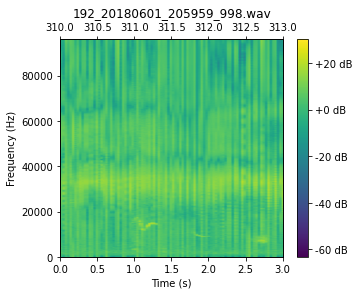

In [69]:
spec_config = {
    'channel': 0, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.1,
     'step': 0.032,
     'freq_min': 0,
     'freq_max': 100000,
     'window_func': 'hamming',
     'duration': 3.0
    }

spec2 = MagSpectrogram.from_wav(
    path=os.path.join(sound_files_path, '192_20180601_205959_998.wav'),
    offset=310,
    **spec_config)
spec2.plot()
plt.show()

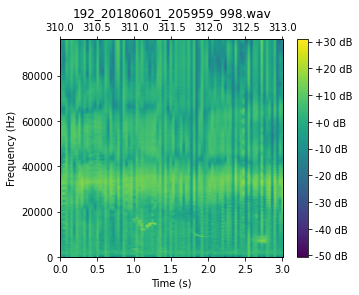

In [72]:
#shorter window
spec_config = {
    'channel': 0, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#          'rate': 100000, #None = use original rate
     'window': 0.085,
     'step': 0.035,
     'freq_min': 0,
     'freq_max': 100000,
     'window_func': 'hamming',
     'duration': 3.0
    }
spec2 = MagSpectrogram.from_wav(
    path=os.path.join(sound_files_path, '192_20180601_205959_998.wav'),
    offset=310,
    **spec_config)
spec2.plot()
plt.show()


We will finally chose this last setting, to build our database.

<a id=section8></a>

<a id=section8></a> 
## 8. Creating the database

Now we have to compute the spectrograms following the settings above for each selection in our selection tables and then save them in a database.

All of this can be done with the ```dbi.create_database``` function in Ketos.

We will start with the training dataset. We need to indicate the name for the database we want to create, where the audio files are, a name for the dataset, the selections table and, finally the audio representation. As specified in our ``spec_cfg``, this is a Magnitude spectrogram, but ketos can also create databases with Power, Mel and CQT spectrograms, as well as time-domain data (waveforms).


In [75]:
spec_config = {
#     'channel': 1, #stereo channel (0 by default)
    'type': 'MagSpectrogram',
#      'rate': 1000, #None = use original rate
     'window': 0.085,
     'step': 0.035,
     'freq_min': 0,
     'freq_max': 100000,
     'window_func': 'hamming',
     'duration': 3.0
    }
#channel arg is shared with create_database method, that's why we move it there:
dbi.create_database(output_file='database_ketos_02.h5', 
                    channel = 0,
                    #data_dir='data/train',
                    data_dir = sound_files_path,
                    dataset_name='train',
                    selections=annotations_df_train,
                    audio_repres=spec_config
                   )                             

100%|██████████| 5455/5455 [37:36<00:00,  2.42it/s]


5455 items saved to database_ketos_02.h5


And we do the same thing for the test set. Note that, by specifying the same database name, we are telling ketos that we want to add the test set to the existing database.

In [76]:
# channel arg is also added there in the same way as previously
dbi.create_database(output_file='database_ketos_02.h5', 
                    channel = 0,
#                     data_dir='data/test',
                    data_dir = sound_files_path,
                    dataset_name='test',
                    selections=annotations_df_test,
                    audio_repres=spec_config
                   )                            

100%|██████████| 1112/1112 [08:38<00:00,  2.14it/s]


1112 items saved to database_ketos_02.h5


Now the database with spectrograms representing 3 seconds audio segments with and without trains of clicks. The data is divided into 'train' and 'test' groups in HDF5 terms. Within each of them there's a dataset called 'data', which contains the spectrograms and respective labels.

In [77]:
db = dbi.open_file("database_ketos_02.h5", 'r')

In [78]:
db

File(filename=database_ketos_02.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/test (Group) ''
/test/data (Table(1112,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(86, 8162), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (1,)
/train (Group) ''
/train/data (Table(5455,), fletcher32, shuffle, zlib(1)) ''
  description := {
  "data": Float32Col(shape=(86, 8162), dflt=0.0, pos=0),
  "filename": StringCol(itemsize=100, shape=(), dflt=b'', pos=1),
  "id": UInt32Col(shape=(), dflt=0, pos=2),
  "label": UInt8Col(shape=(), dflt=0, pos=3),
  "offset": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape 

In [79]:
db.close() #close the database connection

Next step is to build a deep neural network and train it to recognize trains of clicks. 

To get the data from this database:  [database_interface](https://docs.meridian.cs.dal.ca/ketos/modules/data_handling/database_interface.html) module in ketos and the [pyTables](https://www.pytables.org/index.html) documentation.